In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

In [3]:
import pandas as pd
import numpy as np
import talib as ta
import math
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yahooFinance

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

#Neuronales Netz
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [4]:
#den wievielten Tag er vorhersagen soll
forecastDays = 365

# wie viele Tage das Modell shiftet für die Vorhersage (in wie viel Tagen steigen oder fallen)
shifter = 30

#wie viele Tage warten, bis Entscheidung geändert werden kann?
delay = 5

# Wie viele Tage davor in eine Zeile!
lag_steps = 30

In [5]:
ETH = yahooFinance.Ticker("ETH-USD").history(period='max')
BTC = yahooFinance.Ticker("BTC-USD").history(period='max')
BNB = yahooFinance.Ticker("BNB-USD").history(period='max')
XRP = yahooFinance.Ticker("XRP-USD").history(period='max')

kryptos = [ETH, BTC, BNB, XRP]

In [6]:
ETH.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-09-25 00:00:00+00:00,1580.747437,1595.844116,1565.025513,1588.322876,4394930984,0.0,0.0
2023-09-26 00:00:00+00:00,1588.023193,1598.097778,1580.165527,1593.417236,3544861160,0.0,0.0
2023-09-27 00:00:00+00:00,1593.108276,1631.910767,1585.368896,1597.491211,5533036096,0.0,0.0
2023-09-28 00:00:00+00:00,1597.671997,1666.024170,1597.294678,1652.882690,6658092168,0.0,0.0
2023-09-29 00:00:00+00:00,1652.605347,1657.820923,1648.656494,1657.275513,6387015168,0.0,0.0


In [7]:
def calculateIndicator(currency, shifter):
  currency["RSI"] = ta.RSI(currency["Close"], timeperiod = 14)
  currency["ROC"] = ta.ROC(currency["Close"], timeperiod = 10)
  currency["%R"] = ta.WILLR(currency["High"], currency["Low"], currency["Close"], timeperiod = 14)
  currency["OBV"] = ta.OBV(currency["Close"], currency["Volume"])
  currency["MACD"], currency["MACD_SIGNAL"], currency["MACD_HIST"] = ta.MACD(currency["Close"], fastperiod=12, slowperiod=26, signalperiod=9)
  #Wenn der Wert in 5 Tagen höher ist, als heute, dann 1, wenn nicht, dann -1 (da genau gleich sehr unwahrscheinlich ist, gilt dies auch als -1)
  currency["realResult"] = np.where(currency["Close"].shift(-shifter) > currency["Close"], 1, -1)
  currency["realValueInXDays"] = currency["Close"].shift(-shifter)
  #return currency

def add_lag_features(data, lag_steps):
  for i in range(1, lag_steps+1):
    data[f'Open_Lag_{i}'] = data['Open'].shift(i)
  return data.dropna()

In [8]:
# Anzahl der Verzögerungsschritte (vergangene Tage)
for asset in kryptos:
  calculateIndicator(asset, shifter)
  #add_lag_features(asset, lag_steps)

def cleanDF(df):
  df = df.drop("Dividends", axis=1)
  df = df.drop("Stock Splits", axis=1)
  #df = df.drop("High", axis=1)
  #df = df.drop("Low", axis=1)
  df.dropna(inplace = True)
  return df

df = BTC.append((ETH, BNB, XRP))

df = cleanDF(df)
ETH = cleanDF(ETH)


<ipython-input-8-45ffc2123618>:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = BTC.append((ETH, BNB, XRP))


In [9]:
def trainTestSplitRFR(daysToPredict, ETH, df, y):

  splitVal = daysToPredict/len(df.index)
  days = -1*daysToPredict

  # Split train and test
  train_ETH, test_ETH = ETH[0:days], ETH[days:]
  #test_ETH = testETH.drop("realResult", axis = 1)

  train_df, test_df = df[0:days], df[days:]
  #test_df = test_df.drop("realResult", axis = 1)

  #Aufteilen in X und Y und Train und Test
  X_train, X_test = train_df[0:], test_df[0:]
  X_train, X_test = X_train.drop(y, axis=1), X_test.drop(y, axis=1)

  y_train, y_test = train_df[[y]], test_df[[y]]


  X_train_eth, X_test_eth = train_ETH[0:], train_ETH[0:]
  X_train_eth, X_test_eth = X_train_eth.drop(y, axis=1), X_test_eth.drop(y, axis=1)

  y_train_eth = train_ETH[y]
  y_test_eth = test_ETH[y]

  test_ETH = test_ETH.drop(y, axis = 1)

  return  X_train, X_test, y_train, y_test, X_train_eth, X_test_eth, y_train_eth, y_test_eth, train_ETH, test_ETH

def trainTestSplit(daysToPredict, ETH, df, yVal):
  df = df.dropna()
  ETH = ETH.dropna()
  splitVal = daysToPredict/len(df.index)
  days = -1*daysToPredict

  # Split train and test
  train_ETH, test_ETH = ETH[0:days], ETH[days:]
  test_ETH = test_ETH.drop(y, axis = 1)

  X = np.array(df[0:])
  X_eth = np.array(ETH[0:])

  y = np.array(df[yVal])
  y_eth = np.array(ETH[yVal])

  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = splitVal)
  X_train_eth, X_test_eth, y_train_eth, y_test_eth = train_test_split(X_eth, y_eth, random_state = 0, test_size = splitVal)
  return  X_train, X_test, y_train, y_test, X_train_eth, X_test_eth, y_train_eth, y_test_eth, train_ETH, test_ETH

In [10]:
def calc(data):
  truePred = sum(1 for i in range(0,len(data)) if data['predictedTrade'][i] == data['realResult'][i])
  falsePred = sum(1 for i in range(0,len(data)) if data['predictedTrade'][i] != data['realResult'][i])
  all = len(data)
  acc = truePred/all

  print("true: ", truePred)
  print("false: ", falsePred)
  print("all: ", all)
  print("Accurracy: ", round(acc, 4))

def buy_sell(asset, n):
    BuyPrice = []
    SellPrice = []
    flag = -1
    counter = 0

    for i in range(len(asset)):
        if asset["predictedTrade"][i] == 1 and counter == 0:
            if flag != 1:
                BuyPrice.append(asset["Close"][i])
                SellPrice.append(np.nan)
                flag = 1
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        elif asset["predictedTrade"][i] == -1 and counter ==0:
            if flag !=0:
                BuyPrice.append(np.nan)
                SellPrice.append(asset["Close"][i])
                flag = 0
            else:
                BuyPrice.append(np.nan)
                SellPrice.append(np.nan)
        else:
            BuyPrice.append(np.nan)
            SellPrice.append(np.nan)

        counter +=1
        if counter ==n:
            counter = 0

    return (BuyPrice, SellPrice)

#Plotting our Signals on our time period
def plotBuySell(testETH):
  plt.figure(figsize=(16,8))
  plt.scatter(testETH.index, testETH["Buy"], color = "green", label = "Buy", marker = "^", alpha=1)
  plt.scatter(testETH.index, testETH["Sell"], color = "red", label = "Sell", marker = "v", alpha=1)
  plt.plot(testETH.index, testETH["Close"], alpha = 0.5)
  plt.show()

def createBuySell(testETH):
  buysell = buy_sell(testETH, delay)
  testETH["Buy"] = buysell[0]
  testETH["Sell"] = buysell[1]
  #Replacing the first Sell signal by a NaN value
  testETH["Sell"][0] = np.nan
  plotBuySell(testETH)
  return testETH

def performance(data):
    performance = [100]
    num_stocks = 0
    for i in range(len(data)):
        if math.isnan(data["Buy"][i]) == False:
            num_stocks = performance[i]/data["Close"][i]
            performance.append(num_stocks*data["Close"][i])
        elif math.isnan(data["Sell"][i]) == False:
            cash = num_stocks * data["Close"][i]
            performance.append(cash)
        else:
            performance.append(performance[i])


    plt.figure(figsize= (12.6, 4.6))
    plt.plot(performance)
    return performance

In [11]:
def modelTesterBuyOrSell(data):
  calc(data)
  #print(data['predicted'].values)

  createBuySell(data)

  test_stock_performance = performance(data)
  print(test_stock_performance[-1])

<ipython-input-12-cacea9525b9d>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelRFR.fit(X_train, y_train)


true:  276
false:  89
all:  365
Accurracy:  0.7562


<ipython-input-10-8b12da8c65f2>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testETH["Sell"][0] = np.nan


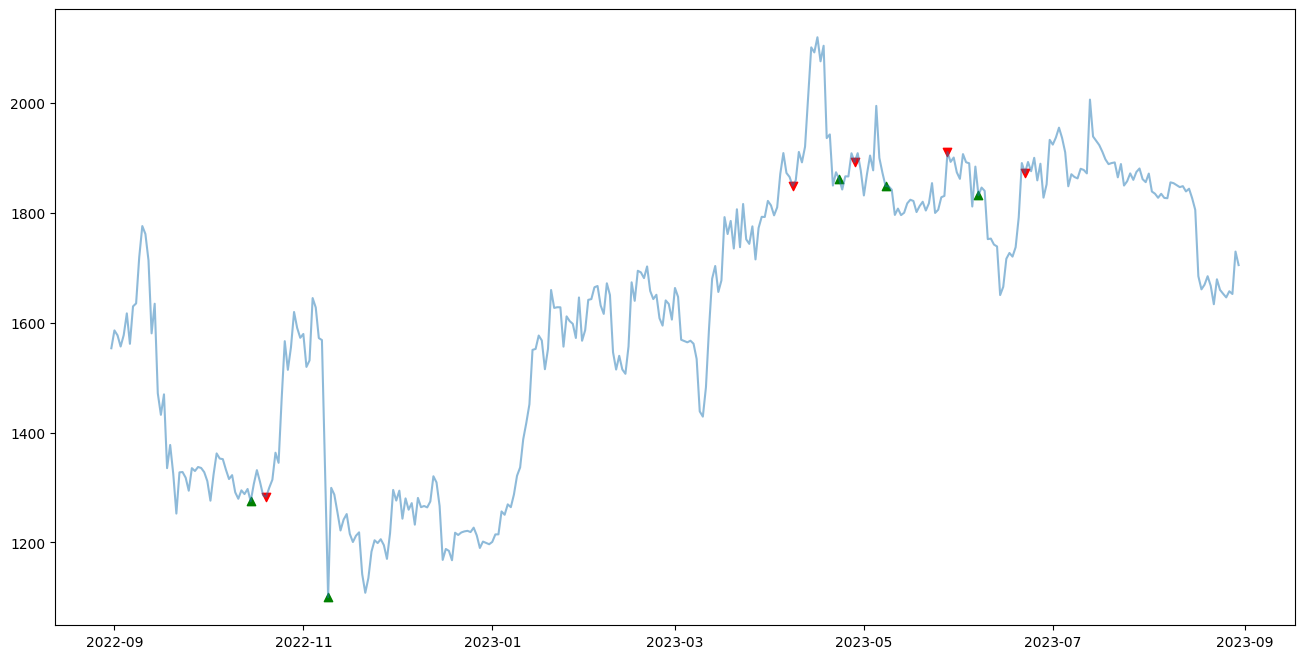

181.66301660968423


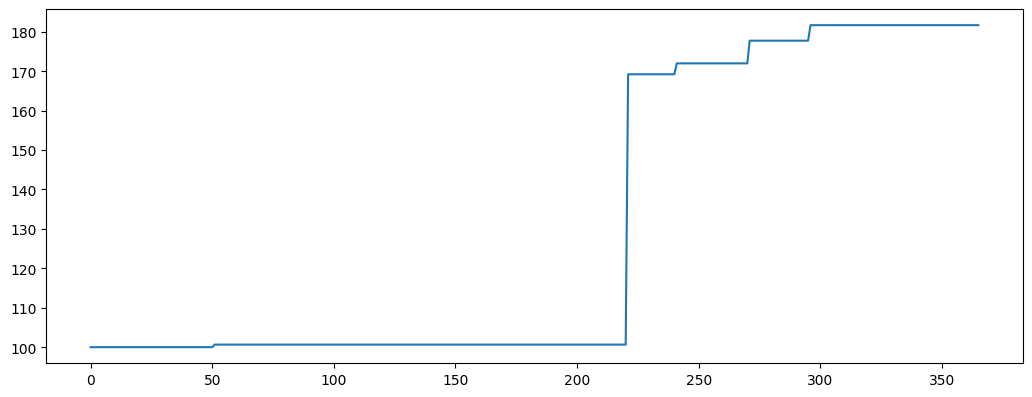

In [12]:
X_train, X_test, y_train, y_test, X_train_eth, X_test_eth, y_train_eth, y_test_eth, train_ETH, test_ETH = trainTestSplitRFR(forecastDays, ETH, df, "realValueInXDays")
#X_train, X_test, y_train, y_test, X_train_eth, X_test_eth, y_train_eth, y_test_eth, train_ETH, test_ETH = trainTestSplitRFR(forecastDays, ETH, df, "realResult")
featureNames_X = ETH.drop("realValueInXDays", axis = 1).columns


# Random Forest Regressor - Get Best Parameter
# hier Random Search einfügen!!
modelRFR = RandomForestRegressor(n_estimators=20, random_state=1, min_samples_split=2, min_samples_leaf=1, max_depth=12, bootstrap=False)
modelRFR.fit(X_train, y_train)


test_ETH['predicted'] = modelRFR.predict(test_ETH)
test_ETH['predictedTrade'] = np.where(test_ETH["predicted"].shift(-shifter) > test_ETH["Close"], 1, -1)
#test_ETH['predictedTrade'] = modelRFR.predict(test_ETH.drop('realResult', axis=1))

modelTesterBuyOrSell(test_ETH)

**XAI-Part**

LIME:

In [ ]:
!pip install interpret
from interpret.blackbox import LimeTabular
from interpret import show

def LimeFunction(mlMethod, X_train_data, X_test_data, y_test_data):
    lime2 = LimeTabular(mlMethod, X_train_data, feature_names = featureNames_X)
    lime_local = lime2.explain_local(X_test_data[-20:-10],y_test_data[-20:-10], name='LIME')
    show(lime_local)


In [16]:
# input (Model, X_train, X_test, y_test)
LimeFunction(modelRFR, X_train, X_test, y_test)

SHAP:

In [ ]:
#https://towardsdatascience.com/explainable-ai-xai-with-shap-regression-problem-b2d63fdca670

!pip install shap
import shap
shapExplainer = shap.TreeExplainer(modelRFR)
shap_values = shapExplainer.shap_values(X_test)

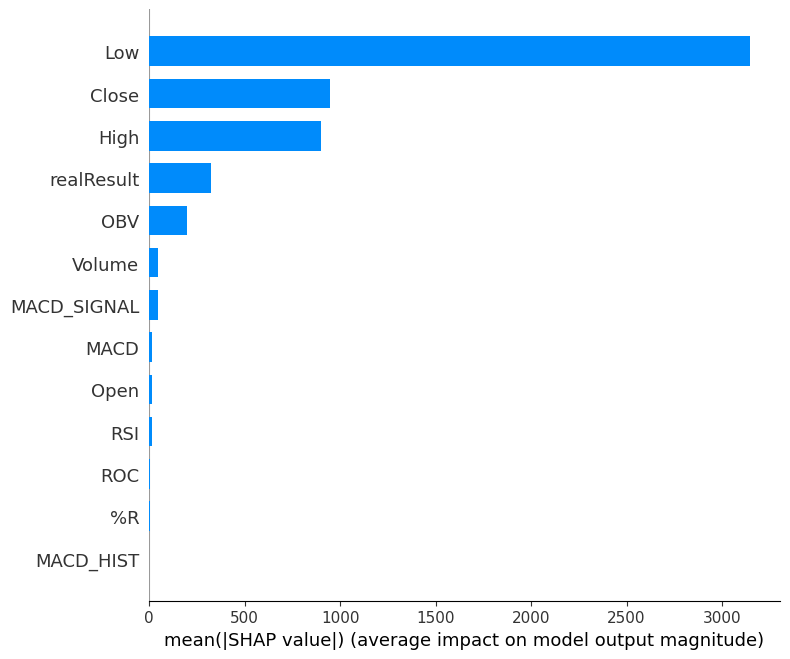

In [18]:
shapExplainer = shap.summary_plot(
    shap_values,
    X_train,
    feature_names=X_train.columns,
    plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


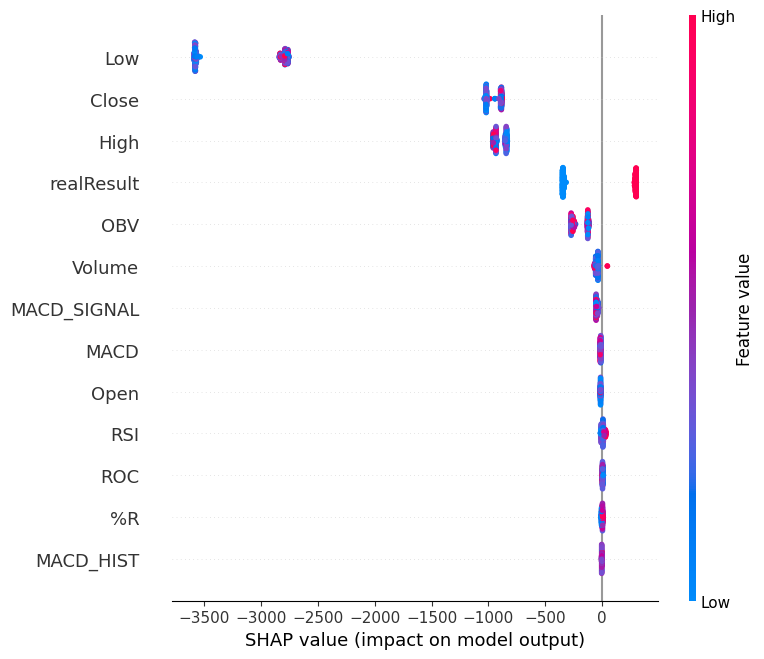

In [19]:
shap.summary_plot(shap_values,X_test,feature_names=X_train.columns)

In [ ]:
print(ETH.tail(30))